In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PySigmoid import *

from sklearn.datasets import  make_circles
import os

In [2]:
def posify(x):
    if type(x) == np.ndarray:
        if len(x.shape) == 1:
            return np.array([Posit(y) for y in x])
        else:
            return np.array([[Posit(z) for z in y] for y in x])
    else:
        return Posit(x)
    
def sigmoid(x):
    if type(x) == np.ndarray:
        if len(x.shape) == 1:
            return np.array([(y).sigmoid() for y in x])
        else:
            return np.array([[(z).sigmoid() for z in y] for y in x])
    else:
        return (x).sigmoid()
    
# def sigmoid_derivative(x):
#         return x * (1 - x)

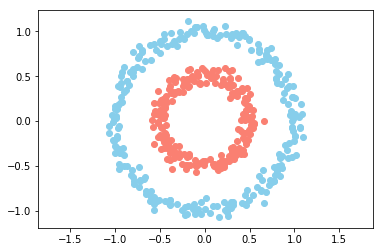

In [3]:
# CREATE THE DATASET

n = 500
p = 2

X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)

# X = posify(X)
# Y = posify(Y)
Y = Y[:, np.newaxis]
plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c='skyblue')
plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c='salmon')
plt.axis('equal')
plt.show()

In [4]:
# NEURAL LAYER CLASS

class neural_layer():
 
  def __init__(self, n_conn, n_neur, act_f, posit=False):
    np.random.seed(1)
    
    self.act_f = act_f
    
    self.b = np.random.rand(1, n_neur)      * 2 - 1
    self.W = np.random.rand(n_conn, n_neur) * 2 - 1
    if posit:
        self.b = posify(self.b)
        self.W = posify(self.W)

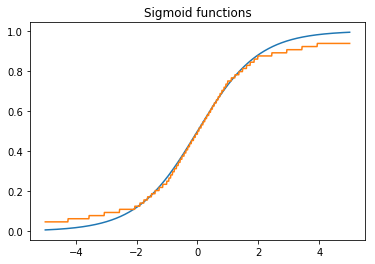

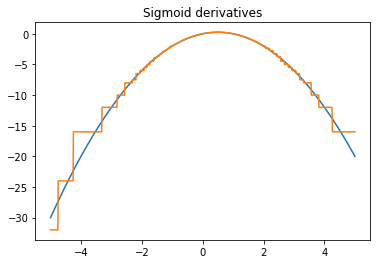

In [5]:
# ACTIVATION FUNCTIONS

sigm = (lambda x: 1 / (1 + np.e ** (-x)),
        lambda x: x * (1 - x))

sigm_posit = (lambda x: sigmoid(x),
        lambda x: x * (1 - x))

relu = lambda x: np.maximum(0, x)

set_posit_env(8,0)
_x = np.linspace(-5, 5, 1000)
plt.plot(_x, sigm[0](_x))
plt.plot(_x, sigm_posit[0](posify(_x)))
plt.title('Sigmoid functions')

plt.figure()
plt.plot(_x, sigm[1](_x))
plt.plot(_x, sigm_posit[1](posify(_x)))
plt.title('Sigmoid derivatives')

plt.show()

In [6]:
# CREATE THE NEURAL NETWORK

def create_nn(topology, act_f, posit=False):
    nn = []
  
    for l, layer in enumerate(topology[:-1]):    
        nn.append(neural_layer(topology[l], topology[l+1], act_f, posit))
    
    return nn

In [7]:
# FUNCION DE ENTRENAMIENTO

def train(neural_net, X, Y, l2_cost, lr=0.5, train=True):  
    out = [(None, X)]
  
    # Forward pass
    for l, layer in enumerate(neural_net):

        z = np.array(Posit.fused_matmult(out[-1][1], neural_net[l].W)) + neural_net[l].b
        a = neural_net[l].act_f[0](z)

        out.append((z, a))

  
    if train:
        # Backward pass 
        deltas = []

        for l in reversed(range(0, len(neural_net))):
            z = out[l+1][0]
            a = out[l+1][1]

            if l == len(neural_net) - 1:
                deltas.insert(0, l2_cost[1](a, Y) * neural_net[l].act_f[1](a))
            else:
                deltas.insert(0, Posit.fused_matmult(deltas[0], _W.T) * neural_net[l].act_f[1](a))

            _W = neural_net[l].W

            # Gradient descent
            neural_net[l].b = neural_net[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr   
            neural_net[l].W = neural_net[l].W - np.array(Posit.fused_matmult(out[l][1].T, deltas[0])) * lr
      
    return out[-1][1]

# topology = [p, 4, 8, 1]
# neural_net = create_nn(topology, sigm)  
# l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
#            lambda Yp, Yr: (Yp - Yr))
  
# train(neural_net, X, Y, l2_cost, 0.5)
# print("")

In [8]:
def plot_NN(neural_n, i, path, posit = False):
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)

    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
        for i1, x1 in enumerate(_x1):
            if posit:
                _Y[i0, i1] = train(neural_n, posify(np.array([[x0, x1]])), posify(Y), l2_cost, train=False)[0][0]
            else:
                _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]

    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
    plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")
    plt.title('{} steps of training'.format(i))
    
    plt.savefig('{}/{}.png'.format(path, i))

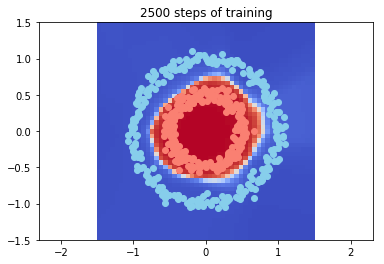

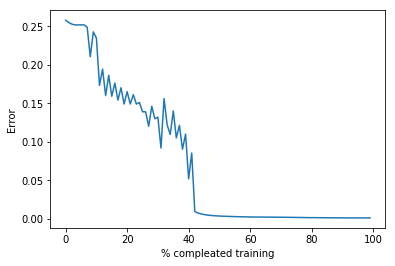

In [9]:
from IPython.display import clear_output
nbits = [14, 16]
for n in nbits:
    set_posit_env(n, 0)
    path = n
    if not os.path.exists(str(path)):
        os.makedirs(str(path))

    topology = [p, 4, 8, 1]
    neural_n = create_nn(topology, sigm_posit, posit=True)
    l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
               lambda Yp, Yr: (Yp - Yr))

    loss = []

    plot_NN(neural_n, 0, path=path, posit=True)

    for i in range(1,2501):

        # Entrenemos a la red!
        pY = train(neural_n, posify(X), posify(Y), l2_cost, lr=0.05)

        if i % 25 == 0:

            loss.append(l2_cost[0](pY, Y))
            plot_NN(neural_n, i, path=path, posit=True)

            clear_output(wait=True)
            plt.show()
            plt.plot(range(len(loss)), loss)
            plt.xlabel('% compleated training')
            plt.ylabel('Error')
            plt.show()